In [1]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from pydicom import dcmread
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

2025-01-10 15:46:17.032950: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-10 15:46:17.061417: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-10 15:46:17.061998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-10 15:46:17.563745: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the dataset
csv_path = '/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/data/Mammo/All_XWalk_Outcome_cleaned.csv'
data = pd.read_csv(csv_path, sep=',', quotechar='"', low_memory=False)

In [3]:
# Check data
print(data.head())

        patient_id               PatientName  PatientDOB OriginalID  \
0  20130102_0g0aud  Roberge^Annette^Patricia  1958-09-17    9093889   
1  20130102_1s02ke             Kim^Myung Soo  1949-12-26    2191507   
2  20130102_4gw29z          Cunnington^Donna  1939-05-18    1093886   
3  20130102_5fjuf1          Lo^Anita^Oi Fong  1951-09-13    2186762   
4  20130102_5ih7tj               Meng^Jinsoo  1952-10-08    2191501   

   StudyDate AccessionNumber  \
0   20130102    104MG1300015   
1   20130102    104MG1300048   
2   20130102    104MG1300018   
3   20130102    104MG1300058   
4   20130102    104MG1300019   

                                            FilePath      SheetName  \
0  Q:\BCWomen\BDenStorage\Screening\20130102\2013...  BCW-Screening   
1  Q:\BCWomen\BDenStorage\Screening\20130102\2013...  BCW-Screening   
2  Q:\BCWomen\BDenStorage\Screening\20130102\2013...  BCW-Screening   
3  Q:\BCWomen\BDenStorage\Screening\20130102\2013...  BCW-Screening   
4  Q:\BCWomen\BDenStorage

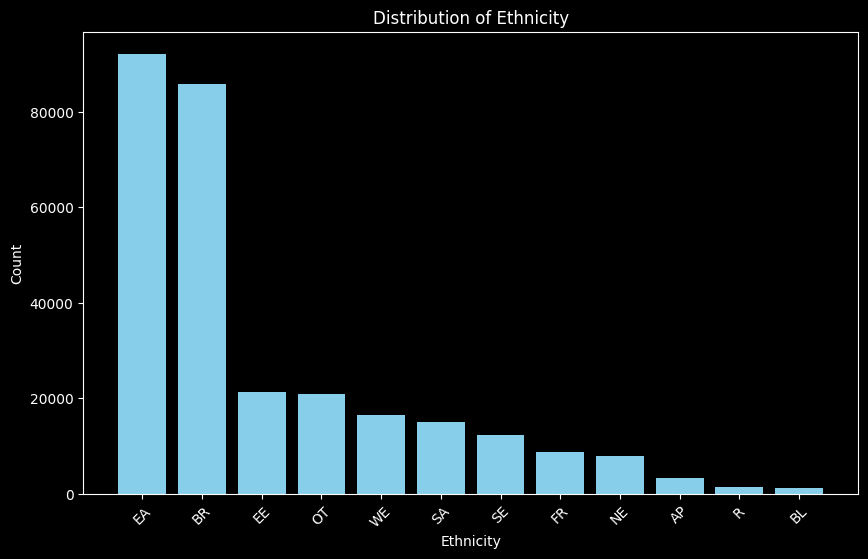

In [4]:
# Show the distribution of ethnicity
ethnicity_counts = data['ethnicity'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='skyblue')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Distribution of Ethnicity')
plt.xticks(rotation=45)
plt.show()

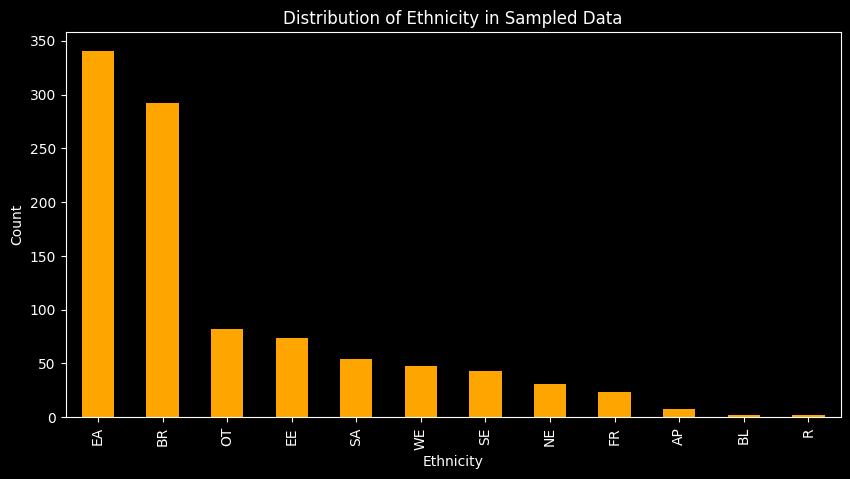

In [5]:
# Randomly select about 1000 images
data_sample = data.sample(n=1000, random_state=42)
# Verify sampled distribution
plt.figure(figsize=(10, 5))
data_sample['ethnicity'].value_counts().plot(kind='bar', color='orange')
plt.title('Distribution of Ethnicity in Sampled Data')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.show()

In [6]:
# Define the correct base path
correct_base_path = "/mnt/disk_share/AIRM"

# Replace 'Q:\\' with the correct base path and standardize separators
data['FilePath'] = data['FilePath'].str.replace(r"^Q:\\", correct_base_path + "/", regex=True)
data['FilePath'] = data['FilePath'].str.replace(r"\\\\|\\", "/", regex=True)  # Replace backslashes with forward slashes

# Debugging: Print sample paths to verify
print(data['FilePath'].head())

0    /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...
1    /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...
2    /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...
3    /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...
4    /mnt/disk_share/AIRM/BCWomen/BDenStorage/Scree...
Name: FilePath, dtype: object


In [7]:
# Filter out rows with invalid or missing FilePath
data_sample = data.sample(n=1000, random_state=42)
data_sample = data_sample.dropna(subset=['FilePath'])  # Remove rows with NaN in FilePath
data_sample = data_sample[data_sample['FilePath'].apply(lambda x: isinstance(x, str))]  # Keep only string paths

valid_filepaths = []
labels = []

for _, row in data_sample.iterrows():
    folder_path = row['FilePath']
    if os.path.exists(folder_path):  # Check if folder exists
        dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.dcm')]
        if dicom_files:  # Check if DICOM files are present
            valid_filepaths.append(os.path.join(folder_path, dicom_files[0]))
            labels.append(row['ethnicity'])

# Display count of valid files
print(f"Number of valid DICOM files: {len(valid_filepaths)}")

Number of valid DICOM files: 994


In [8]:
# Convert labels to numeric format
def encode_labels(labels):
    label_mapping = {label: idx for idx, label in enumerate(set(labels))}
    encoded_labels = [label_mapping[label] for label in labels]
    return encoded_labels, label_mapping

encoded_labels, label_mapping = encode_labels(labels)

# Prepare dataset for training
train_paths, test_paths, train_labels, test_labels = train_test_split(
    valid_filepaths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
)

In [ ]:
# Data augmentation and preprocessing
def preprocess_image(filepath):
    dicom = dcmread(filepath.numpy().decode('utf-8'))  # Ensure filepath is processed as a string
    image = dicom.pixel_array.astype('float32')  # Convert pixel array to float32
    image = tf.image.resize(image, [224, 224])  # Resize to 224x224 for EfficientNetB0
    image = tf.expand_dims(image, axis=-1)  # Add channel dimension if grayscale
    image = tf.image.grayscale_to_rgb(image)  # Convert to RGB
    return image

# Wrapper for TensorFlow compatibility
def preprocess_image_tf(filepath, label):
    image = tf.py_function(func=preprocess_image, inp=[filepath], Tout=tf.float32)
    image.set_shape((224, 224, 3))  # Set shape for TensorFlow graph
    label = tf.py_function(func=lambda x: tf.convert_to_tensor(x, dtype=tf.int32), inp=[label], Tout=tf.int32)  # Convert label to integer
    return image, label

# Create TensorFlow datasets
def create_dataset(filepaths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(preprocess_image_tf)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare datasets
train_dataset = create_dataset(train_paths, train_labels)
test_dataset = create_dataset(test_paths, test_labels)

In [18]:
# Build EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(label_mapping), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
for image, label in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

2025-01-10 15:54:05.162155: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'
Traceback (most recent call last):

  File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_721075/2146992370.py", line 5, i

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'
Traceback (most recent call last):

  File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_721075/2146992370.py", line 5, in preprocess_image
    image.get_shape().as_list()  # []

AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

2025-01-10 15:54:06.345036: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'
Traceback (most recent call last):

  File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_721075/2146992370.py", line 5, i

In [12]:
# Train the model
model.fit(train_dataset, validation_data=test_dataset, epochs=30)

Epoch 1/30


ValueError: in user code:

    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1085, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1179, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 577, in update_state
        self.build(y_pred, y_true)
    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 483, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 631, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 631, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 652, in _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    ValueError: as_list() is not defined on an unknown TensorShape.
